In [1]:
# https://arxiv.org/pdf/2508.06069

In [2]:
import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.ensemble import HistGradientBoostingRegressor

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
seed: int = sum(map(ord, "seed"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [4]:
def make_regression_data(
    rng: np.random.Generator, n_samples: int
) -> tuple[np.ndarray, np.ndarray]:
    x1 = rng.uniform(0, 1, size=n_samples)
    x2 = rng.uniform(0, 1, size=n_samples)
    y = (
        (x1 + x2 - 0.5) ** 2
        - x1**3
        - 0.5
        + np.sin(2 * np.pi * x1 * x2**2)
        + rng.normal(0, 0.1, size=n_samples)
    )
    return np.c_[x1, x2], y

In [5]:
x, y = make_regression_data(rng=rng, n_samples=700)

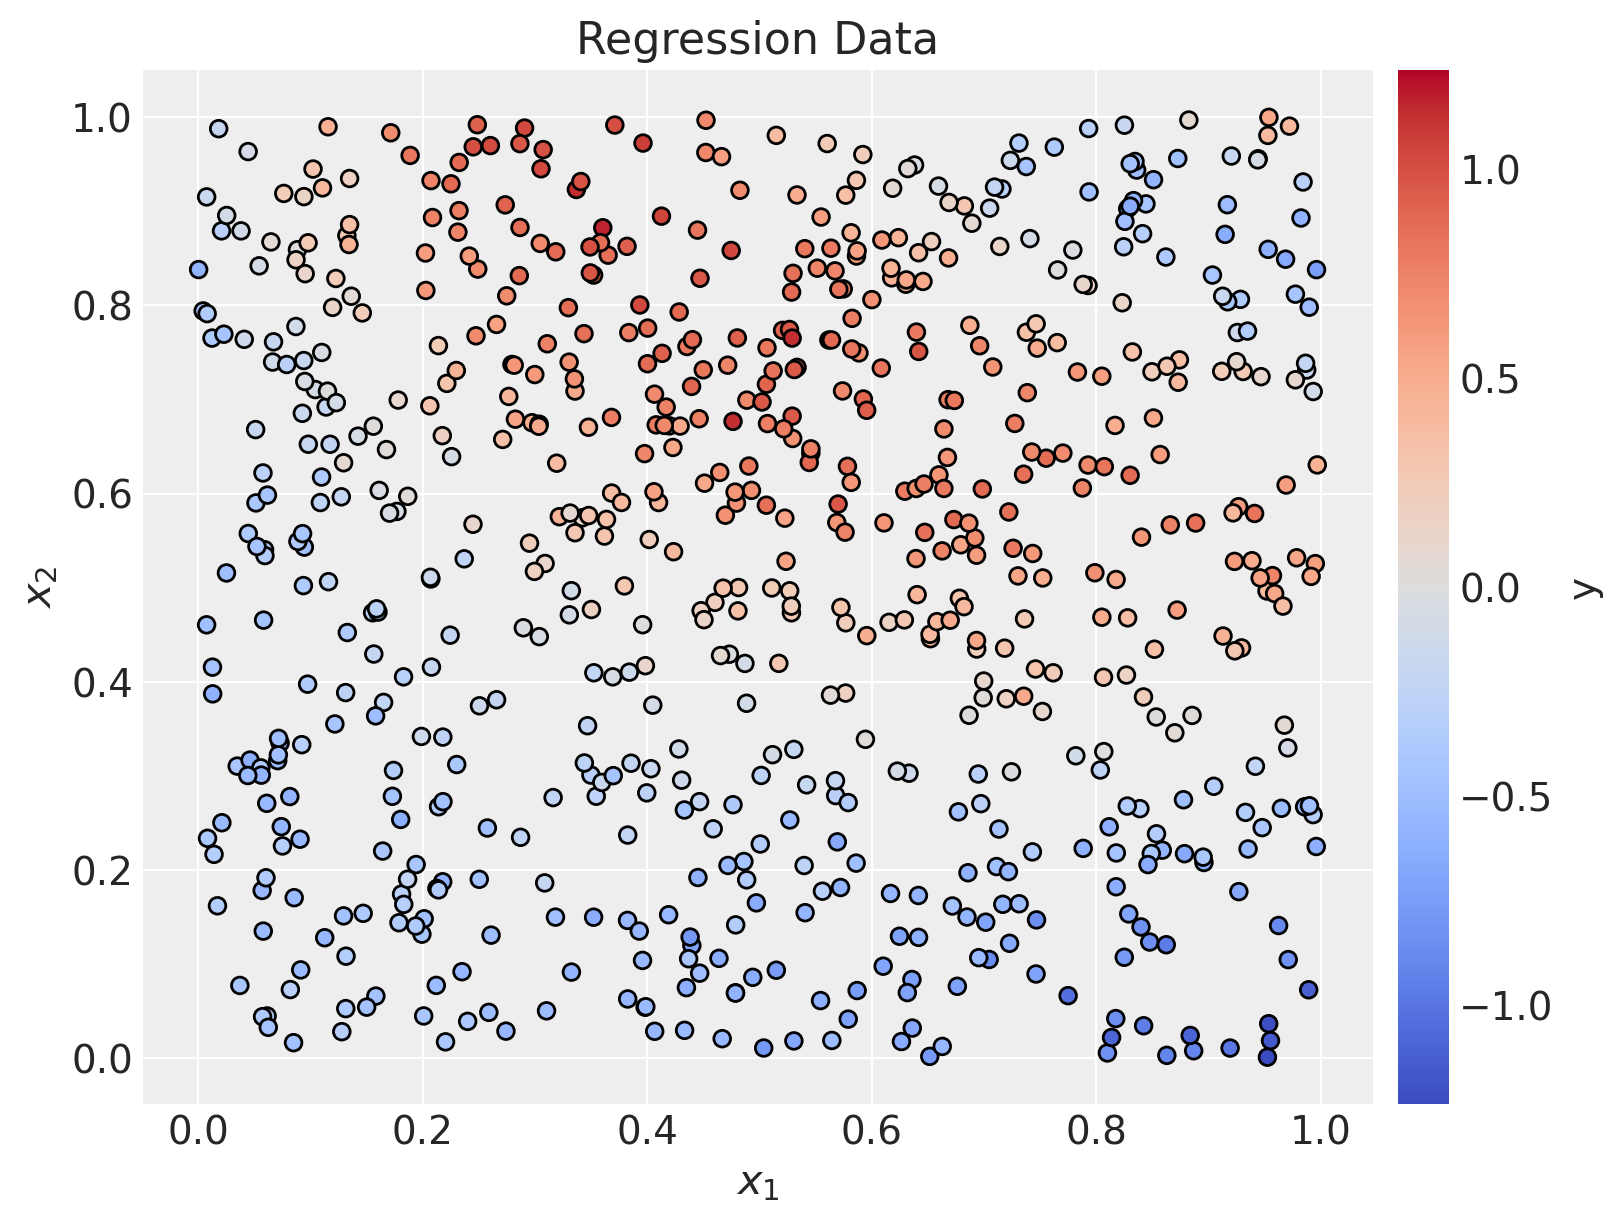

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

norm = mcolors.Normalize(vmin=-np.max(np.abs(y)), vmax=np.max(np.abs(y)))
sc = ax.scatter(x[:, 0], x[:, 1], c=y, cmap="coolwarm", norm=norm, edgecolors="black")
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label("y", fontsize=14)
ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$", title="Regression Data");

In [7]:
model = HistGradientBoostingRegressor()

model.fit(x, y)

HistGradientBoostingRegressor()

In [8]:
y_pred = model.predict(x)

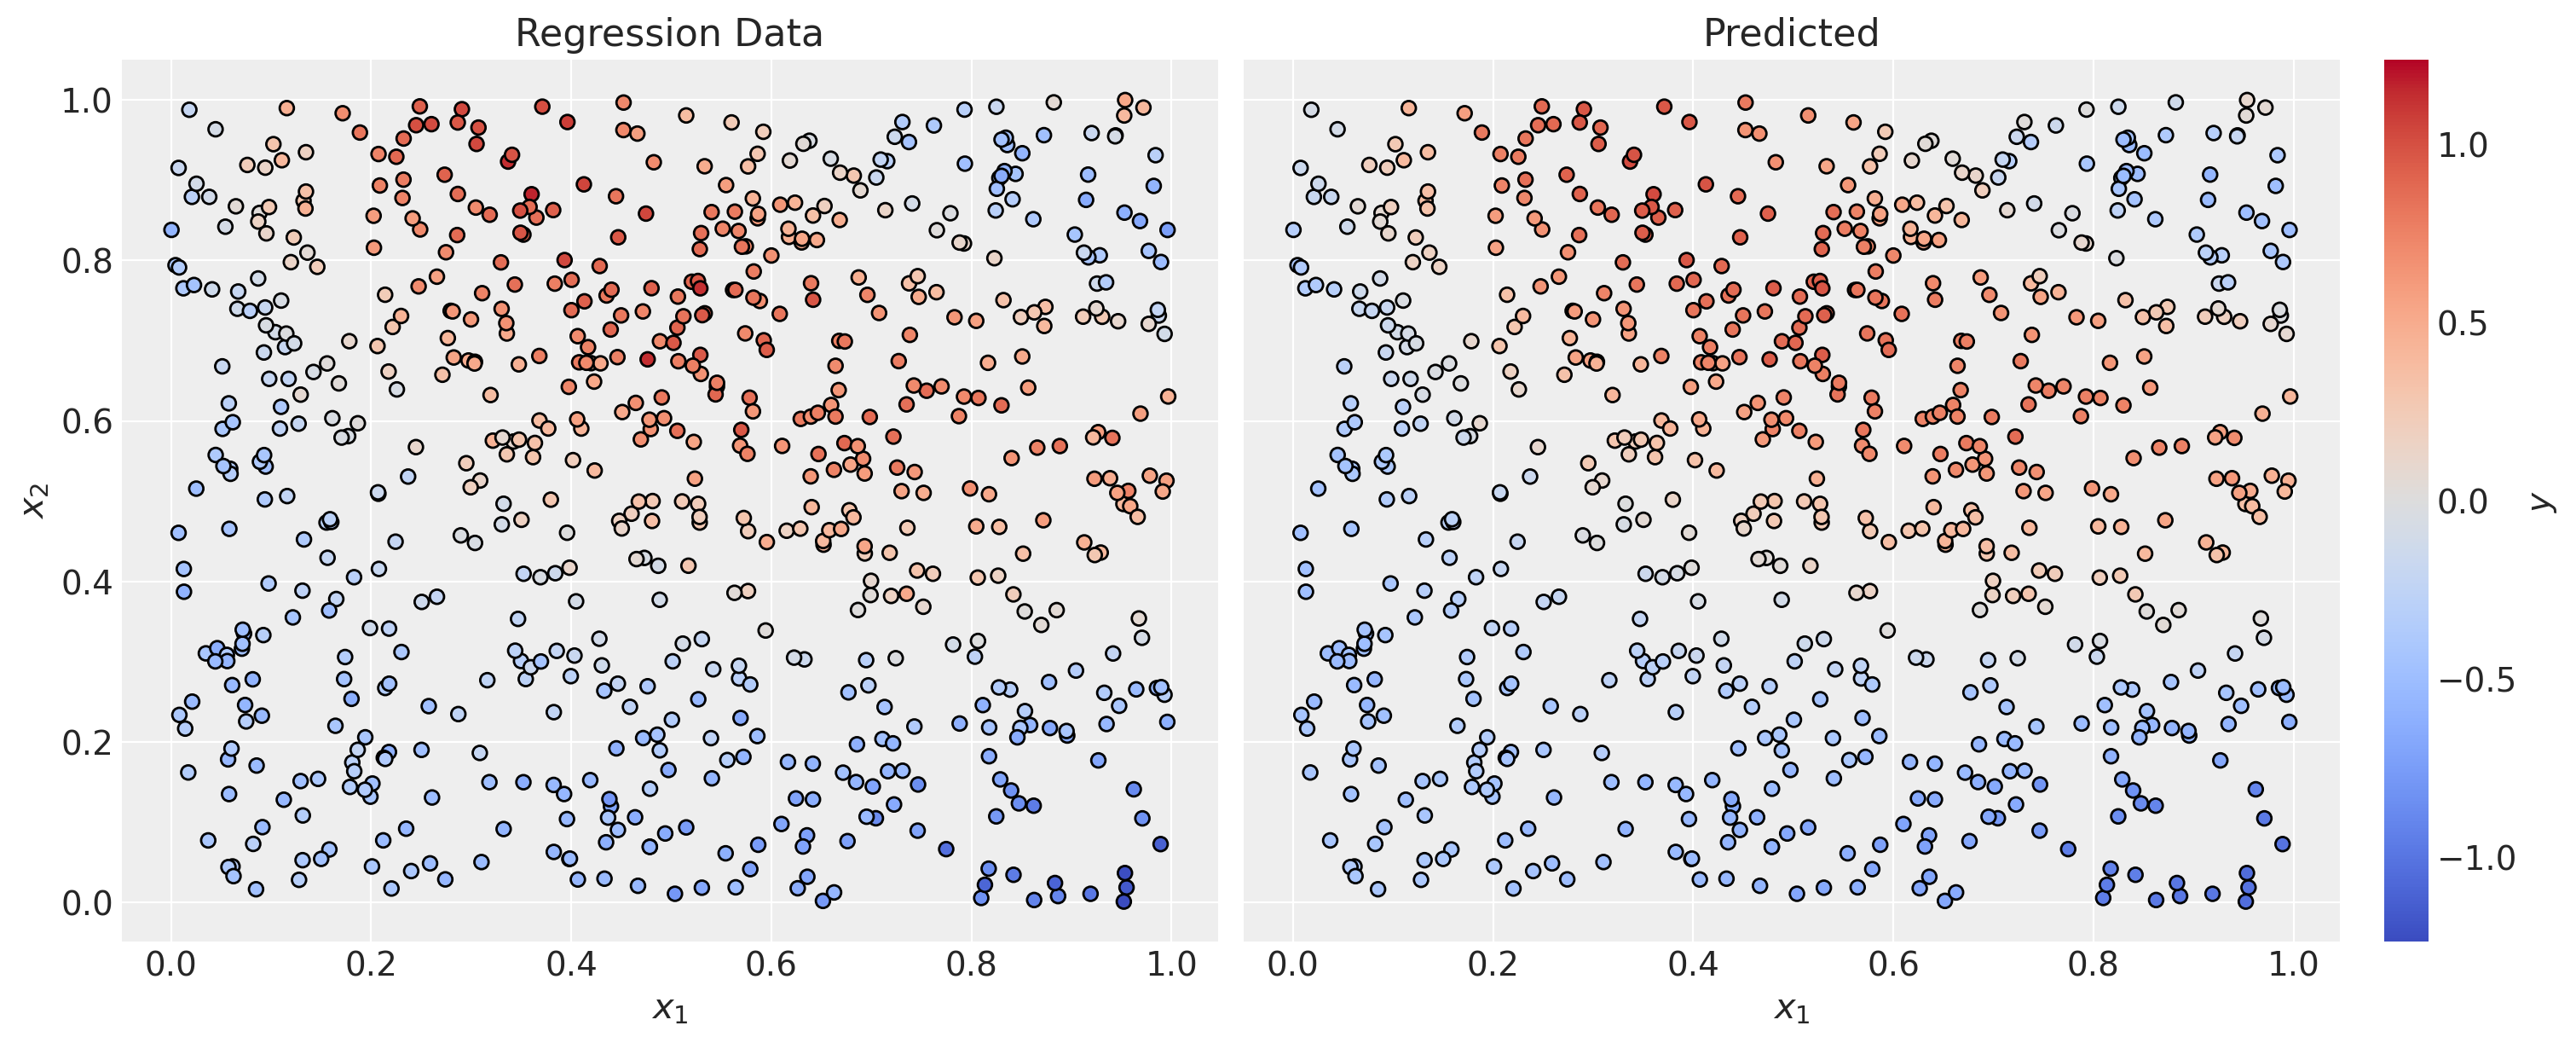

In [9]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 6), layout="constrained"
)

sc_0 = ax[0].scatter(
    x[:, 0], x[:, 1], c=y, cmap="coolwarm", norm=norm, edgecolors="black"
)

norm = mcolors.Normalize(vmin=-np.max(np.abs(y)), vmax=np.max(np.abs(y)))
cbar = plt.colorbar(sc_0, ax=ax, pad=0.02)
cbar.set_label(r"$y$", fontsize=14)


ax[0].set(xlabel=r"$x_1$", ylabel=r"$x_2$", title="Regression Data")

sc_1 = ax[1].scatter(
    x[:, 0], x[:, 1], c=y_pred, cmap="coolwarm", norm=norm, edgecolors="black"
)
ax[1].set(xlabel=r"$x_1$", ylabel=None, title="Predicted");

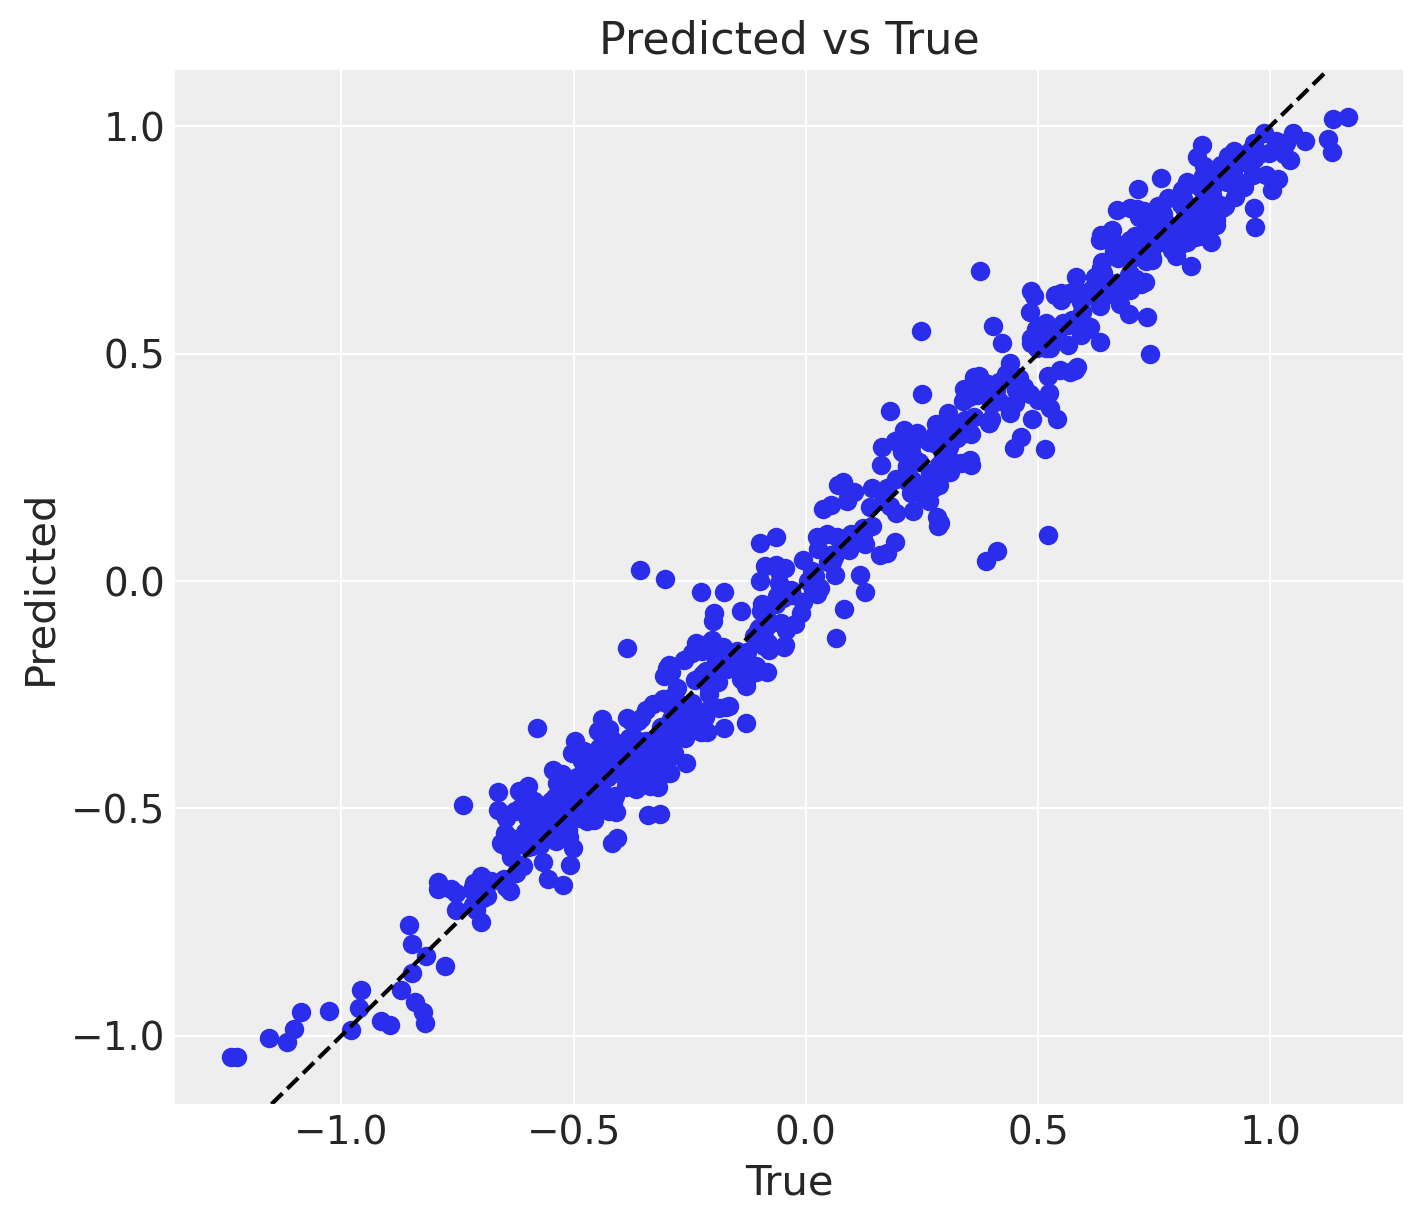

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y, y_pred)
ax.axline(xy1=(0, 0), slope=1, color="black", linestyle="--")
ax.set(xlabel="True", ylabel="Predicted", title="Predicted vs True");

In [11]:
x2_fixed = 0.65


def model_predict_at_x2_fixed(x1: float, x2_fixed: float) -> float:
    return model.predict(np.c_[x1, x2_fixed]).item()


x1_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
y_pred_grid = np.vectorize(model_predict_at_x2_fixed)(x1_grid, x2_fixed)

In [12]:
mask = np.abs(x[:, 1] - x2_fixed) < 0.1

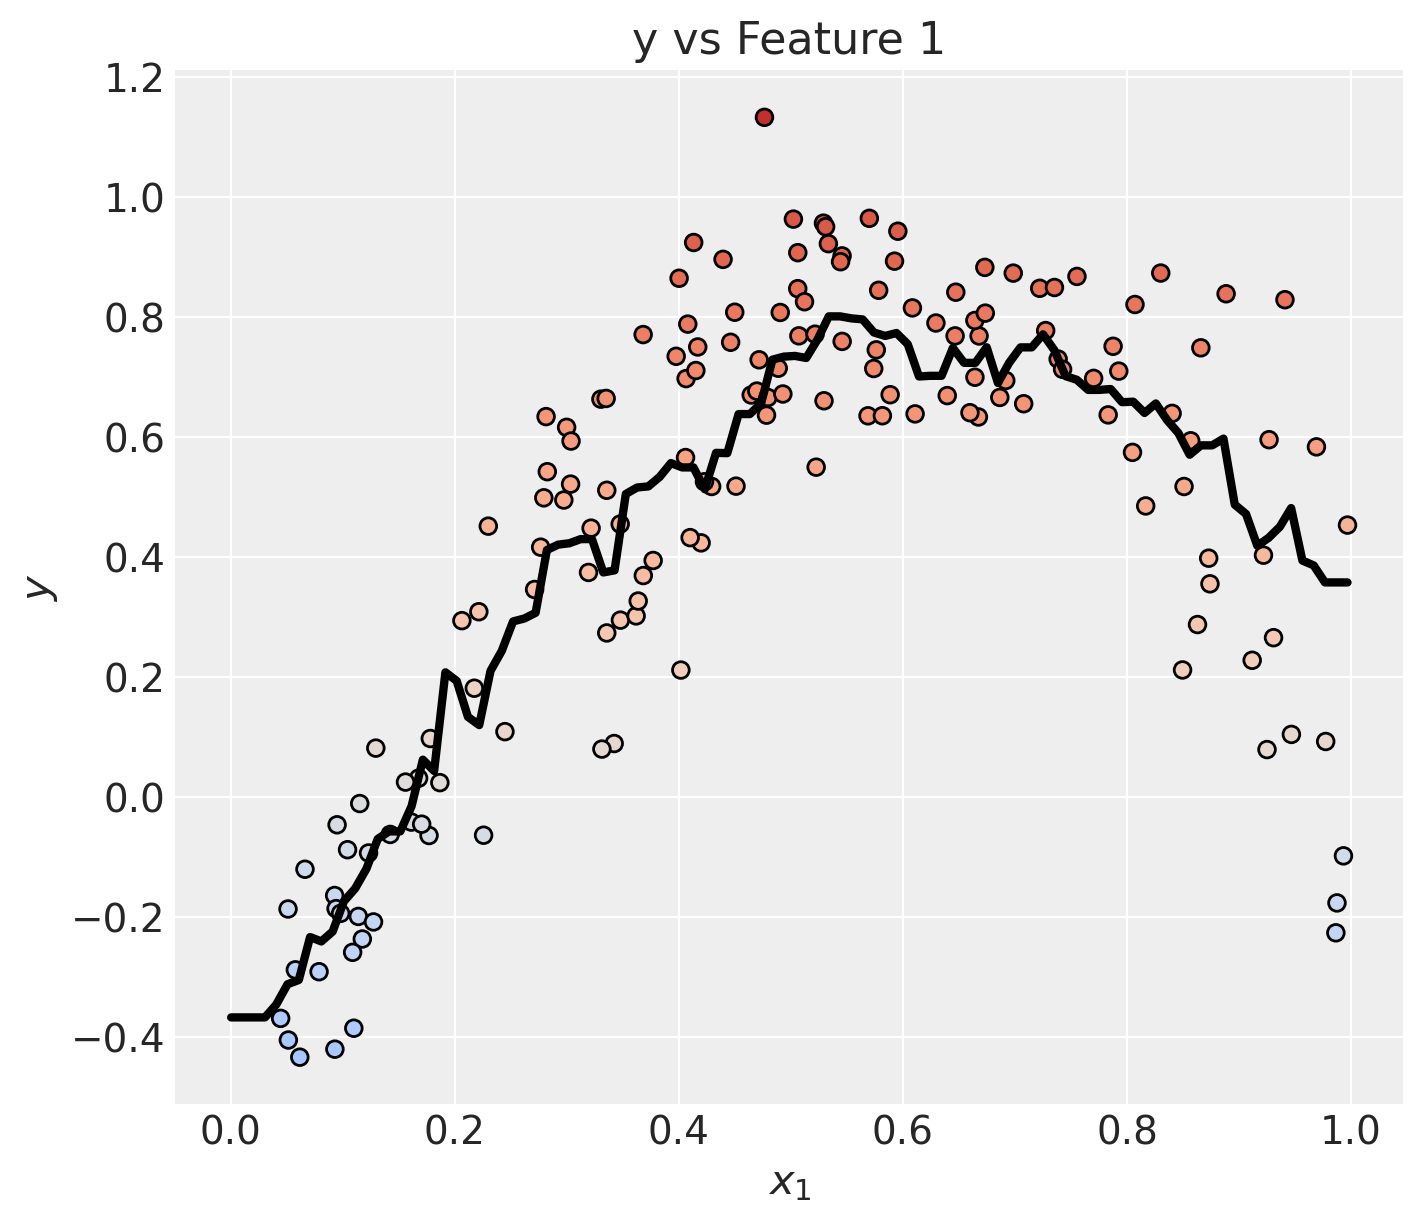

In [13]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(
    x[:, 0][mask], y[mask], c=y[mask], cmap="coolwarm", norm=norm, edgecolors="black"
)
ax.plot(x1_grid, y_pred_grid, c="black", linewidth=3)
ax.set(xlabel=r"$x_1$", ylabel=r"$y$", title="y vs Feature 1");

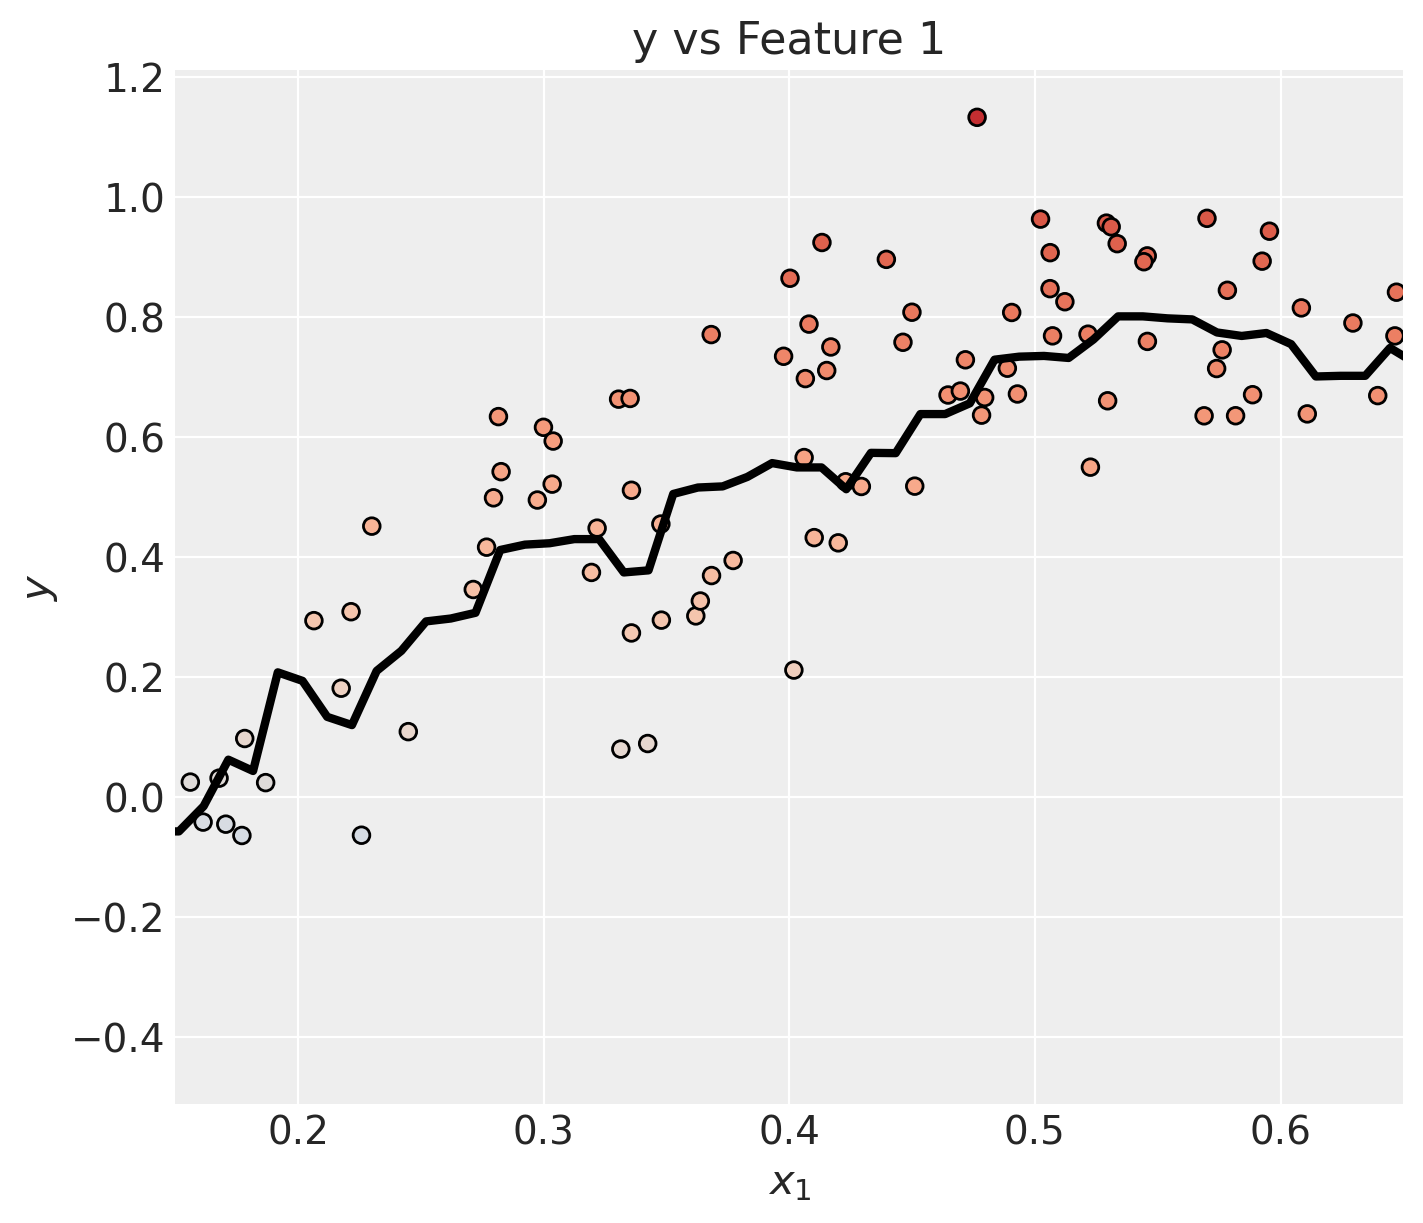

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(
    x[:, 0][mask], y[mask], c=y[mask], cmap="coolwarm", norm=norm, edgecolors="black"
)
ax.plot(x1_grid, y_pred_grid, c="black", linewidth=3)
ax.set(xlabel=r"$x_1$", ylabel=r"$y$", title="y vs Feature 1", xlim=(0.15, 0.65));

In [ ]:
# Note: Tree-based models have piecewise constant predictions,
# so gradient-based optimizers (default BFGS) won't work
# ( because the gradient is zero almost everywhere).
# Use a gradient-free method like Nelder-Mead or Powell.


y_target = 0.5

bounds = (0.2, 0.6)
x0 = (bounds[1] + bounds[0]) / 2


def function_to_minimize(x, x2_fixed, y_target):
    return abs(model_predict_at_x2_fixed(x, x2_fixed) - y_target)


optimization_result = minimize(
    function_to_minimize,
    x0=0.4,
    args=(x2_fixed, y_target),
    method="Powell",
    bounds=[bounds],
)

optimization_result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.004673598436508053
       x: [ 3.528e-01]
     nit: 2
   direc: [[ 1.000e+00]]
    nfev: 24

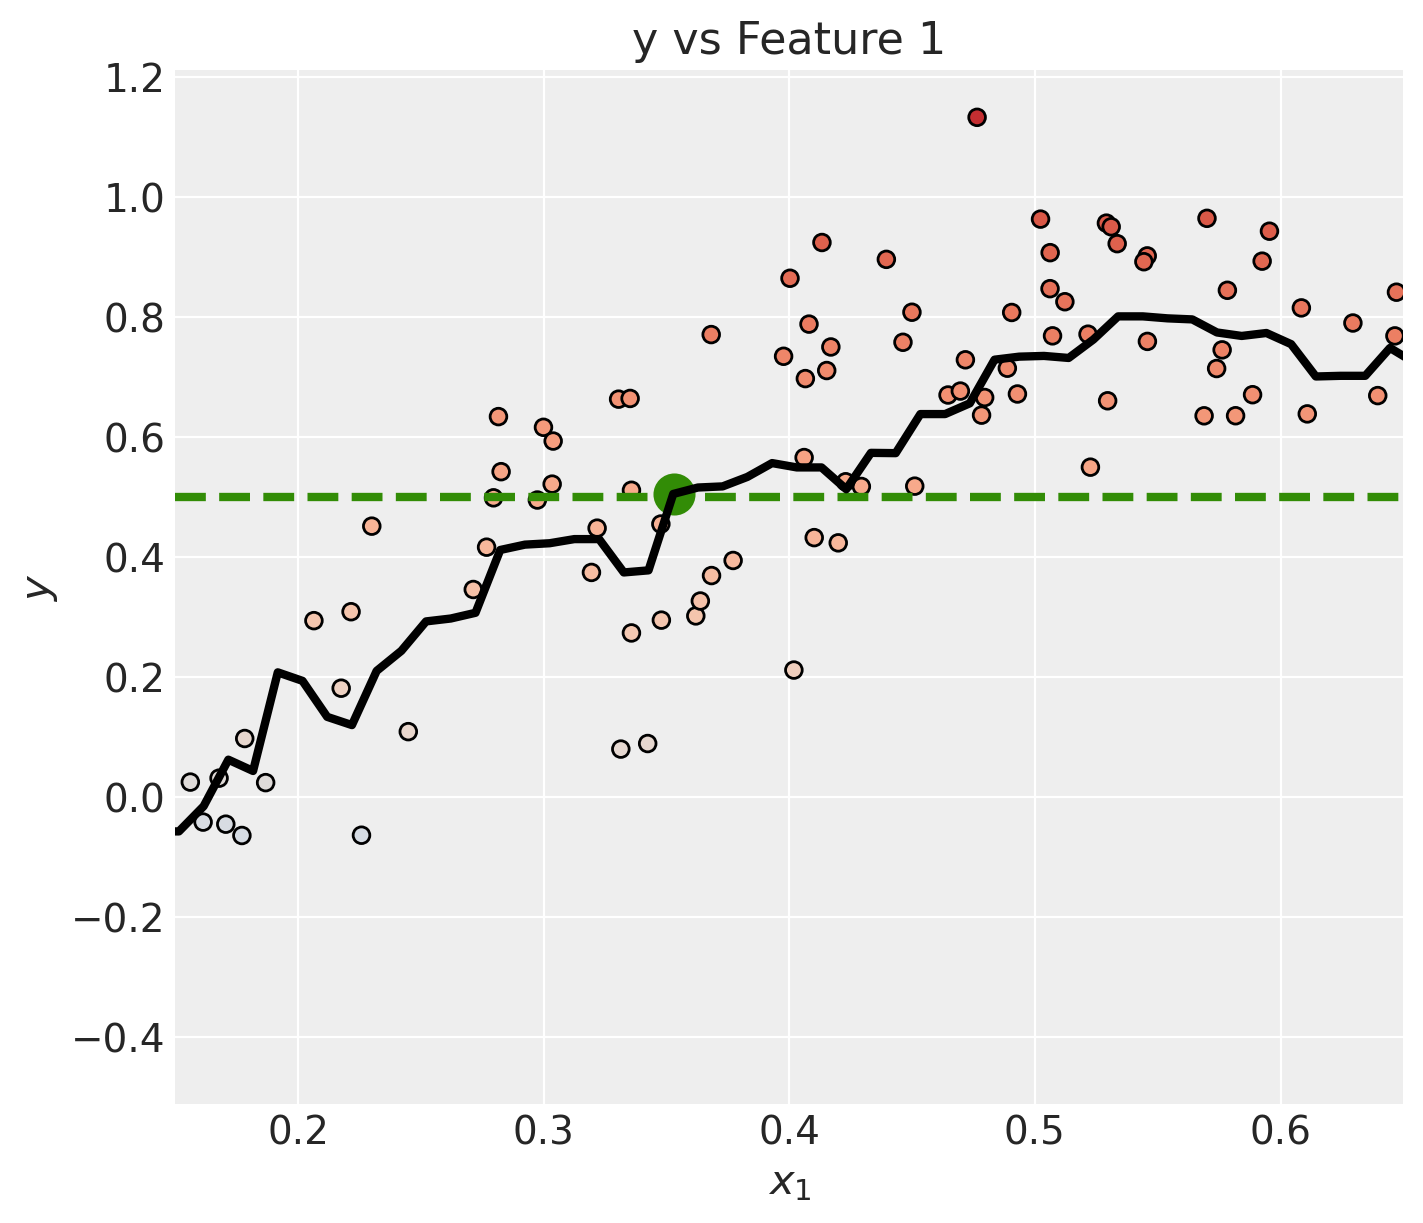

In [16]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(
    x[:, 0][mask], y[mask], c=y[mask], cmap="coolwarm", norm=norm, edgecolors="black"
)
ax.axhline(y_target, color="C2", linestyle="--", linewidth=3)
ax.plot(x1_grid, y_pred_grid, c="black", linewidth=3)
ax.scatter(
    optimization_result.x,
    optimization_result.fun + y_target,
    c="C2",
    marker="o",
    s=200,
)
ax.set(xlabel=r"$x_1$", ylabel=r"$y$", title="y vs Feature 1", xlim=(0.15, 0.65));